<span style="font-size:16pt">
<p style="text-align: center;">
    МИНОБРНАУКИ РОССИИ <br>
    РГУ НЕФТИ И ГАЗА (НИУ) ИМЕНИ И.М. ГУБКИНА<br>
    ФАКУЛЬТЕТ АВТОМАТИКИ И ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ<br>
    КАФЕДРА АВТОМАТИЗИРОВАННЫХ СИСТЕМ УПРАВЛЕНИЯ<br>  <br>
    ДИСЦИПЛИНА <br>
        «Теория принятия решений. Нечеткие модели»
    <br><br> <br> <br> <br> <br>
    ОТЧЁТ <br>
    по лабораторной работе №4 <br>
    «Нечёткий лес<br> <br> <br> <br> <br>  <br><br>
</p>

<p style="text-align: right;">
    Выполнил:<br>
    студент группы АС-21-05, Негробов В.А.<br>
    Проверил:<br>
    Манзюк Н.Ю.<br><br> <br> <br> <br> <br><br> <br> <br>

<p style="text-align: center;">
    МОСКВА 2025
</p>
   </span>

# Подключение библиотек

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

Дерево решений – широко известный и популярный метод автоматического анализа данных, в основе которого лежит обучение на примерах. Правила представлены в виде иерархической последовательной структуры, где каждый объект принадлежит конкретному узлу.

Однако может возникнуть случай, когда точно классифицировать объект по тому или иному признаку довольно трудно. Эти ситуации разрешаются благодаря возможностям нечеткой логики, когда говорят не просто о принадлежности к кому-то классу, признаку, атрибуту, а о её степени. При использовании нечетких деревьев решений (fuzzy decision trees) не теряются знания о том, что объект может обладать свойствами как одного признака, так и другого в той или иной мере.

Главной идеей в таком подходе является сочетание возможностей деревьев решений и нечеткой логики.

Отличительной чертой деревьев решений является то, что каждый пример определенно принадлежит конкретному узлу. В нечетком случае это не так. Для каждого атрибута необходимо выделить несколько его лингвистических значений и определить степени принадлежности примеров к ним. Вместо количества примеров конкретного узла нечеткое дерево решений группирует их степень принадлежности. Коэффициент – это соотношение примеров Dj∈SN
 узла N
 для целевого значения i
, вычисляемый как:

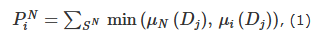

где $\mu_N(D_j)$
 – степень принадлежности примера Dj
 к узлу N
, $\mu_i(D_j)$
 – степень принадлежности примера относительно целевого значения i
, $S_N$
 – множество всех примеров узла N
. Затем находим коэффициент $P_N$
, обозначающий общие характеристики примеров узла N
. В стандартном алгоритме дерева решений определяется отношение числа примеров, принадлежащих конкретному атрибуту, к общему числу примеров. Для нечетких деревьев используется отношение $\frac{{P_i}^N}{P^N}$
, для расчета которого учитывается степень принадлежности.

In [4]:
class FuzzyDecisionTree:
    def __init__(self, max_depth=3, min_samples_split=2, k=10):
        """
        max_depth: максимальная глубина дерева
        min_samples_split: минимальное число образцов для разбиения узла
        k: параметр, определяющий «размытие» разделения (чем больше k, тем резче разделение)
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.k = k
        self.tree = None

    def fit(self, X, y):
        """
        Метод для обучения дерева на данных.
        Args:
            X: матрица признаков (n_samples, n_features)
            y: целевой вектор (n_samples,)
        Returns:
           None
        """
        self.n_classes = len(np.unique(y))
        data = np.hstack([X, y.reshape(-1,1)])
        self.tree = self._build_tree(data, depth=0)

    @staticmethod
    def get_candidate_thresholds(values):
        """
        Функция для получения кандидатов на пороговые значения для разбиения.
        Args:
            values: вектор значений признака (n_samples,)
        Returns:
           thresholds: вектор кандидатов на пороговые значения (n_samples-1,)
        """
        return (values[:-1] + values[1:]) / 2
    
    @staticmethod
    def calculate_fuzzy_weights(feature_values, threshold, k):
        """
        Функция для вычисления весов для левого и правого поддерева.
        Args:
            feature_values: вектор значений признака (n_samples,)
            threshold: пороговое значение
            k: параметр нечёткости
        Returns:
           left_weights: веса для левого поддерева (n_samples,)
           right_weights: веса для правого поддерева (n_samples,)
        """
        left_weights = 1 / (1 + np.exp(k * (feature_values - threshold)))
        right_weights = 1 - left_weights
        return left_weights, right_weights
    
    @staticmethod
    def calculate_weighted_impurity(left_distribution, right_distribution, left_total, right_total):
        """
        Функция для вычисления взвешенной неопределённости.
        Args:
            left_distribution: распределение классов в левом поддереве (n_classes,)
            right_distribution: распределение классов в правом поддереве (n_classes,)
            left_total: сумма весов в левом поддереве (скаляр)
            right_total: сумма весов в правом поддереве (скаляр)
        Returns:
           weighted_impurity: взвешенная неопределённость (скаляр)
        """
        impurity_left = 1 - np.sum((np.array(left_distribution)/left_total)**2) if left_total > 0 else 0
        impurity_right = 1 - np.sum((np.array(right_distribution)/right_total)**2) if right_total > 0 else 0

        return (left_total * impurity_left + right_total * impurity_right) / (left_total + right_total)


    def _build_tree(self, data, depth):
        """
        Рекурсивная функция для построения дерева.
        Args:
            data: данные для построения узла (n_samples, n_features + 1)
            depth: текущая глубина узла
        Returns:
            node: узел дерева (словарь)
        """
        # Если достигнута максимальная глубина или слишком мало образцов, создаём лист
        if depth == self.max_depth or len(data) < self.min_samples_split:
            distribution = {}
            for c in np.unique(data[:,-1]):
                distribution[c] = np.mean(data[:,-1] == c)
            return {'is_leaf': True, 'class_distribution': distribution}

        best_feature = None
        best_threshold = None
        best_impurity = np.inf
        best_split = None

        n_features = data.shape[1] - 1
        # Перебор всех признаков и кандидатов для порога
        for feature in range(n_features):
            values = data[:, feature]
            unique_vals = np.unique(values)
            if len(unique_vals) == 1:
                continue
            # Используем средние точки между отсортированными уникальными значениями
            candidate_thresholds = self.get_candidate_thresholds(unique_vals)
            for threshold in candidate_thresholds:
                # Вычисляем степень принадлежности к левой ветке с помощью сигмоидальной функции
                left_weights, right_weights = self.calculate_fuzzy_weights(data[:, feature], threshold, self.k)

                total_left = np.sum(left_weights)
                total_right = np.sum(right_weights)
                if total_left < 1e-6 or total_right < 1e-6:
                    continue

                # Расчёт нечеткой (взвешенной) классификации для каждой ветки
                left_distribution = {}
                right_distribution = {}
                for c in range(self.n_classes):
                    mask = (data[:,-1] == c)
                    w_left = np.sum(left_weights[mask])
                    w_right = np.sum(right_weights[mask])
                    left_distribution[c] = w_left
                    right_distribution[c] = w_right

                left_total = np.sum(list(left_distribution.values()))
                right_total = np.sum(list(right_distribution.values()))


                weighted_impurity = self.calculate_weighted_impurity(list(left_distribution.values()), list(right_distribution.values()), left_total, right_total)
                if weighted_impurity < best_impurity:
                    best_impurity = weighted_impurity
                    best_feature = feature
                    best_threshold = threshold
                    best_split = (left_weights, right_weights)

        # Если не найдено подходящего разбиения, создаём лист
        if best_feature is None:
            distribution = {}
            for c in np.unique(data[:,-1]):
                distribution[c] = np.mean(data[:,-1] == c)
            return {'is_leaf': True, 'class_distribution': distribution}

        # "Жёсткое" разбиение: каждый объект идёт в ту ветку, к которой у него степень принадлежности больше
        crisp_assignments = best_split[0] >= best_split[1]
        left_data = data[crisp_assignments]
        right_data = data[~crisp_assignments]

        left_tree = self._build_tree(left_data, depth+1)
        right_tree = self._build_tree(right_data, depth+1)
        return {
            'is_leaf': False,
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_tree,
            'right': right_tree
        }

    def _predict_sample(self, x, node):
        """
        Вспомогательная функция для предсказания для одного объекта
        Args:
           x (np.array): Вектор признаков объекта
           node (dict): Узел дерева, с которого начинается предсказание
        Returns:
          dict: Словарь с вероятностями классов для данного объекта
        """
        # Рекурсивный проход по дереву
        if node['is_leaf']:
            return node['class_distribution']
        feature = node['feature']
        threshold = node['threshold']
        left_weight = 1 / (1 + np.exp(self.k * (x[feature] - threshold)))
        right_weight = 1 - left_weight
        left_pred = self._predict_sample(x, node['left'])
        right_pred = self._predict_sample(x, node['right'])
        # Агрегация предсказаний с учётом нечетких весов
        combined = {}
        for c in range(self.n_classes):
            combined[c] = left_weight * left_pred.get(c, 0) + right_weight * right_pred.get(c, 0)
        return combined

    def predict(self, X):
        """
        Функция для предсказания классов для множества объектов
        Args:
            X (np.array): Матрица признаков объектов, для которых нужно сделать предсказание
        Returns:
            np.array: Вектор предсказанных классов для каждого объекта
        """
        preds = []
        for i in range(X.shape[0]):
            distribution = self._predict_sample(X[i], self.tree)
            pred_class = max(distribution, key=distribution.get)
            preds.append(pred_class)
        return np.array(preds)

In [5]:
class FuzzyRandomForest:
    """ Класс для реализации нечеткого случайного леса """
    def __init__(self, n_estimators=10, max_depth=3, min_samples_split=2, k=10):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.k = k
        self.trees = []

    def fit(self, X, y):
        """
        Построение леса на основе обучающей выборки X и меток y
        Args:
            X (np.array): Матрица признаков обучающей выборки
            y (np.array): Вектор меток классов для обучающей выборки
        Returns:
            None
        """
        n_samples, n_features = X.shape
        for i in range(self.n_estimators):
            # Bootstrap-подвыборка
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            tree = FuzzyDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                k=self.k
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        """
        Функция для предсказания классов для множества объектов
        Args:
            X (np.array): Матрица признаков объектов, для которых нужно сделать предсказание
        Returns:
            np.array: Вектор предсказанных классов для каждого объекта
        """
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(X))
        predictions = np.array(predictions)  # форма (n_estimators, n_samples)
        final_predictions, _ = mode(predictions, axis=0)
        return final_predictions.flatten()

In [6]:
def print_tree(node, indent=""):
    """
    Рекурсивная печать структуры дерева в консоль.
    Args:
        node (dict): Узел дерева, который нужно напечатать.
        indent (str): Отступ для форматирования вывода. По умолчанию пустая строка.
    Returns:
       None
    """
    if node['is_leaf']:
        print(indent + "Лист:", {k: float(round(v, 2))
                                 for k, v in node['class_distribution'].items()})
    else:
        print(indent + f"Разбиение: feature[{node['feature']}] < {float(node['threshold']):.2f}")
        print(indent + " -> Левая ветка:")
        print_tree(node['left'], indent + "  ")
        print(indent + " -> Правая ветка:")
        print_tree(node['right'], indent + "  ")

# Данные используемые для обучения

В наборе данных представлены записи об о 150 цветках ириса, данные о каждом цветке расположены в отдельной строке.
В первых четырёх столбцах записаны характеристики цветка: длина наружной доли околоцветника в сантиметрах, длина внутренней доли околоцветника в сантиметрах, ширина наружной доли околоцветника в сантиметрах, ширина внутренней доли околоцветника в сантиметрах. В пятом столбце записано название вида цветка.

В наборе данных представлены три вида ириса: Iris setosa, Iris versicolor и Iris virginica.

In [7]:
data_path = r'data\Iris.csv'
target_var = 'Species'
df = pd.read_csv(data_path, index_col='Id')
df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
146,6.7,3.0,5.2,2.3,Iris-virginica
147,6.3,2.5,5.0,1.9,Iris-virginica
148,6.5,3.0,5.2,2.0,Iris-virginica


Построение графика Boxplot для каждого признака в DataFrame с использованием библиотеки Matplotlib и Seaborn. B 
Boxplot - это график, который условно изображает статистические данные в виде прямоугольника (ящика), у которого есть усы. Boxplot показывает распределение данных и выявляет выбросы. Он состоит из коробки (box), усов (whiskers) и точек (outliers). Коробка охватывает интерквартильный размах (IQR), усы простираются до минимального и максимального значений, не считая выбросов, а выбросы отмечаются отдельными точками.

Boxplot позволяет визуально оценить медиану, квартили, размах и выбросы в данных.

<Axes: >

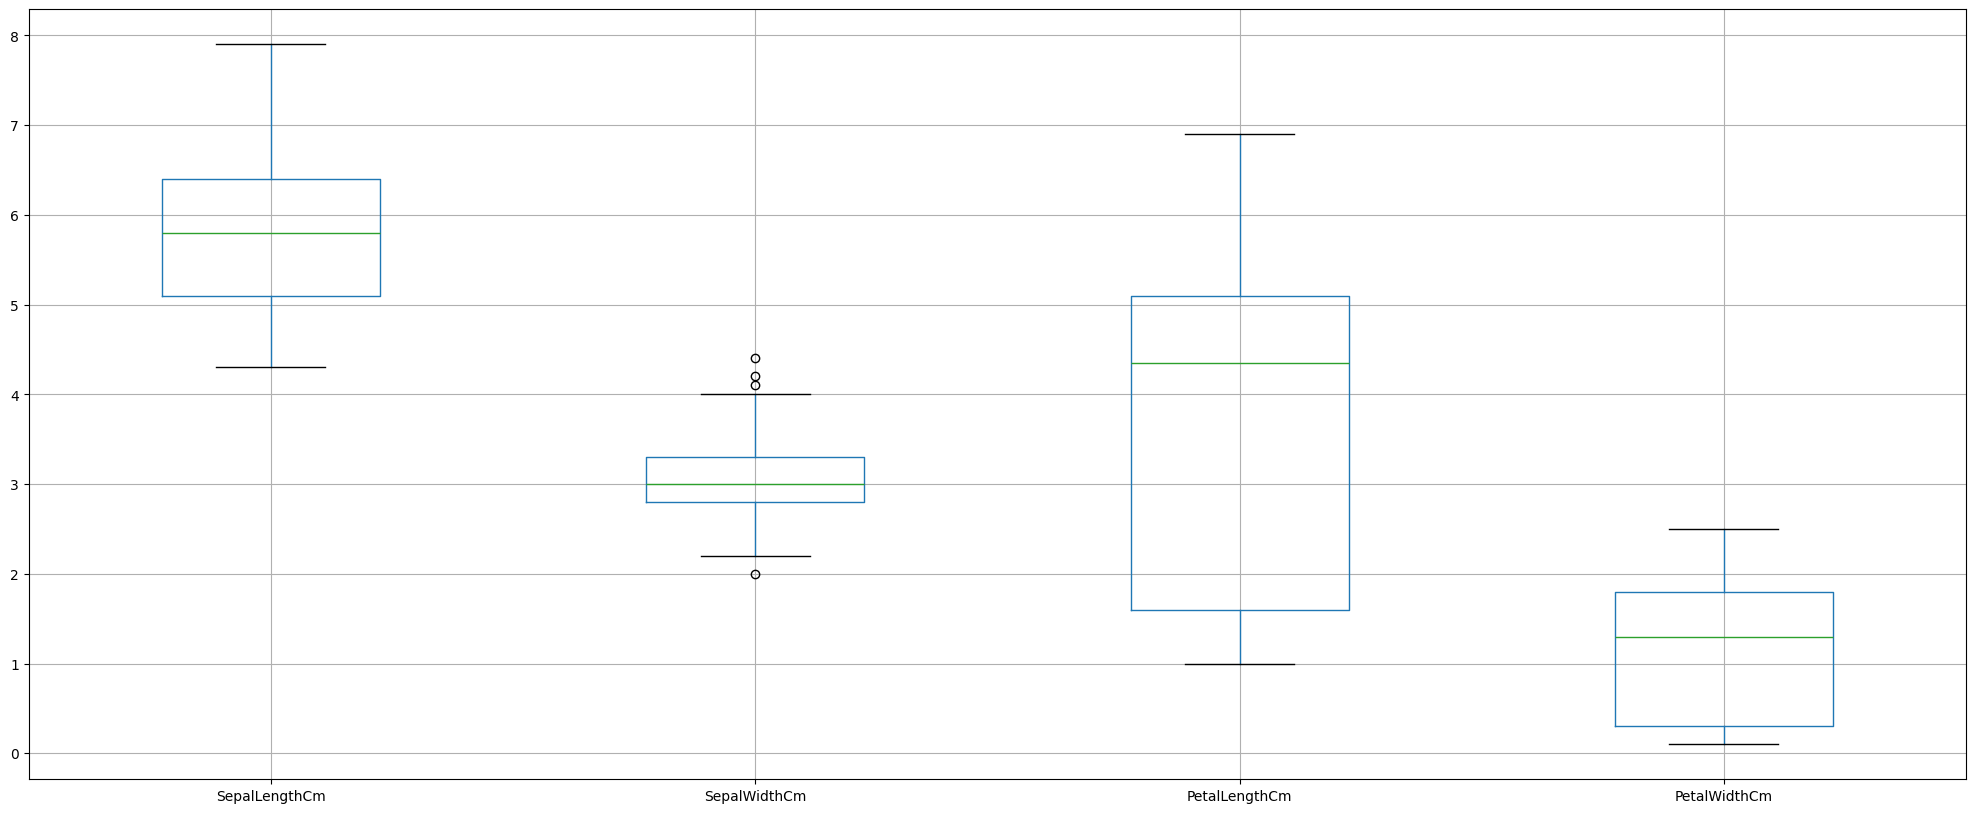

In [8]:
plt.figure(figsize=(25, 10))
df.boxplot()

Количество записей для каждого класса данных одинаковое

<Axes: xlabel='Species', ylabel='Count'>

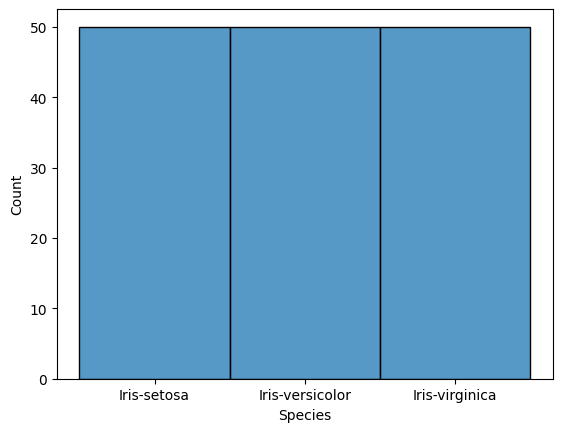

In [9]:
sns.histplot(data=df, x=target_var, fill=True, binwidth=1)

In [10]:
X = df.drop(target_var, axis=1).values
y = df[target_var].values
X.shape, y.shape

((150, 4), (150,))

Кодирование вида цветка (диапазон от 0 до 2 включительно)

In [11]:
le = LabelEncoder()
y = le.fit_transform(y)
y.min(), y.max()

(np.int64(0), np.int64(2))

In [12]:
# Разделение данных на тренировочный и тестовый наборы

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

# Чёткий случайный лес

Использование чёткого случайного леса как Baseline решения задачи
Baseline - это простая модель, которая используется в качестве отправной точки для сравнения с более сложными моделями.

In [ ]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

Чёткий случайный лес решает задачу идеально, так как значения всех метрик равны 1. Это означает, что модель идеально предсказывает классы для всех объектов в тренировочном и тестовом набо

In [14]:
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(1.0, 1.0)

In [15]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        39

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



In [16]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



# Нечёткий случайный лес

Использование реализованного нечёткого случайного леса для решения задачи классификации цветков иррисов

In [17]:
forest = FuzzyRandomForest(
    n_estimators=100,
    max_depth=4,
    min_samples_split=10,
    k=10
)

forest.fit(X_train, y_train)

In [18]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

Нечёткий случайный лес на тестовой выборке также показывает идеальные результаты, что означает, что модель идеально предсказывает классы для всех объектов в тестовом наборе.
Однако, на тренировочной выборке модель показывает неидеальные результаты, что может быть связано с некими выбросами в данных.

In [19]:
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.9666666666666667, 1.0)

In [20]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.93      0.95        41
           2       0.93      0.97      0.95        39

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



In [21]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



Визуализация одного из нечётких решающий деревьевьев из нечёткого случайного леса

In [22]:
print_tree(forest.trees[0].tree)

Разбиение: feature[2] < 2.70
 -> Левая ветка:
  Разбиение: feature[0] < 4.35
   -> Левая ветка:
    Лист: {np.float64(0.0): 1.0}
   -> Правая ветка:
    Разбиение: feature[0] < 4.45
     -> Левая ветка:
      Лист: {np.float64(0.0): 1.0}
     -> Правая ветка:
      Разбиение: feature[0] < 4.55
       -> Левая ветка:
        Лист: {np.float64(0.0): 1.0}
       -> Правая ветка:
        Лист: {np.float64(0.0): 1.0}
 -> Правая ветка:
  Разбиение: feature[2] < 4.85
   -> Левая ветка:
    Разбиение: feature[3] < 1.70
     -> Левая ветка:
      Разбиение: feature[0] < 5.10
       -> Левая ветка:
        Лист: {np.float64(1.0): 1.0}
       -> Правая ветка:
        Лист: {np.float64(1.0): 1.0}
     -> Правая ветка:
      Лист: {np.float64(1.0): 0.33, np.float64(2.0): 0.67}
   -> Правая ветка:
    Разбиение: feature[2] < 5.20
     -> Левая ветка:
      Разбиение: feature[0] < 6.50
       -> Левая ветка:
        Лист: {np.float64(1.0): 0.08, np.float64(2.0): 0.92}
       -> Правая ветка:
        